In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5

#Quick fudge to make import from ../Scripts work
sys.path.append('../../Scripts')

#Custom imports
# for color map
import seaborn as sns
# for reading datafiles 
import pandas as pd

# import script that has formation channel classification functions:
from PostProcessingScripts import * 

import ClassCOMPAS     as CC ###


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [34]:
nModels=17
BPSnameslist = list(string.ascii_uppercase)[0:nModels]

physicalNamesBPSmodelsWithEnter = [r'\textbf{fiducial}',\
                           r'$\beta=0.25$', r'$\beta=0.5$',  r'$\beta=0.75$',r'\textbf{unstable}' + '\n'+ r'\textbf{case BB}',\
                           r'$\alpha_{\rm{CE}}=0.5$',  r'$\alpha_{\rm{CE}}=2$', r'\textbf{optimistic}' +'\n' + r'\textbf{CE}',\
                          r'\textbf{rapid SN}', r'$\rm{max} \ m_{\rm{NS}}$' +'\n' + r'$2.0\,\rm{M}_{\odot}$', r'$\rm{max} \ m_{\rm{NS}}$' +'\n' + r'$3.0\,\rm{M}_{\odot}$',\
                          r'\textbf{no PISN}', r'\textbf{SN} '+ r'$\sigma_{\rm{rms}}^{\rm{1D}}$' +'\n' + r'$100\,\rm{km}\,\rm{s}^{-1}$',r'\textbf{SN} '+ r'$\sigma_{\rm{rms}}^{\rm{1D}}$' +'\n' + r'$30\,\rm{km}\,\rm{s}^{-1}$',\
                          r'\textbf{SN} '+ r'$v_{\rm{k,BH}}$' +'\n' + r'$0\,\rm{km}\,\rm{s}^{-1}$' , r'$\rm{f}_{\rm{WR}} = 0.1$', r'$\rm{f}_{\rm{WR}} = 5$']

alphabetPhysicalNameDictWithEnter =  {BPSnameslist[i]: physicalNamesBPSmodelsWithEnter[i] for i in range(len(BPSnameslist))}





def kde_comapre(axe_ind=None, xparam='MNS', BPSmodelNames=['A'], MSSFRmodelNames=['000'], DCOtypes=['BHNS', 'NSNS'], xvarrange=None, xlabel='xlabel', ylabel='ylabel', \
                              xlim=[1,30], ylim=[0, None], whichWeight='det', path_dir='/Volumes/Andromeda/DATA/AllDCO_bugfix/', quantiles=False,\
                  pathQuantiles='/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/dataFiles/summary_data_Fig_4_5_6/'):
    
    
    """ 
    plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    """
    
    
    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
 
    DCOname_dict = {'BHNS':'BHNS', 'BBH':'BHBH', 'BNS':'NSNS'}

   

    lw=5

            
            
    for DCOtype in DCOtypes:
        
        DCOname = DCOname_dict[DCOtype] 
        print('now at DCO', DCOtype)
        for ind_m, BPSmodelName in enumerate(BPSmodelNames):
            print('now at m=', BPSmodelName)

            
            # data for KDE / PDF:
            path_ = path_dir + alphabetDirDict[BPSmodelName] +'/'
            path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'   
            fdata = h5.File(path)


            # just a lot of lines to obtain the right parameter:
            if xparam in ['Mass1', 'Mass2', 'q', 'Mchirp', 'Mtot', 'MNS']:
                # obtain BH and NS masses
                xvar1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
                xvar2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
                M1, M2 = obtainM1BHandM2BHassymetric(m1=xvar1, m2=xvar2) # M1 will be the most massive, M2 the least massive compact object. 
                del xvar1
                del xvar2
                if xparam =='Mtot':
                    xvar=M1+M2
                elif xparam=='Mass1':
                    xvar = M1
                elif xparam=='Mass2':
                    xvar = M2 
                elif xparam =='q':
                    xvar = M1/M2
                elif xparam=='Mchirp':
                    xvar = chirpmass(M1,M2)
                elif xparam =='MNS':
                    if DCOtype=='BHNS':
                        xvar = M2 # we want the NS not the BH 
                    elif DCOname=='NSNS':
                        xvar = M1 # we want most massive NS 

                del M1
                del M2


            elif xparam=='logZ':
                ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
                xvar = np.log10((ZZ))
                del ZZ 

            elif xparam=='Z':
                ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
                xvar = ((ZZ))
                del ZZ
            elif xparam=='tc':
                tc = fdata['doubleCompactObjects']['tc'][...].squeeze()
                xvar = tc / 1000. # in Gyr. 
                del tc

            elif xparam=='tdelay':
                tc = fdata['doubleCompactObjects']['tc'][...].squeeze()
                tform = fdata['doubleCompactObjects']['tform'][...].squeeze()
                xvar = (tc/1000) + (tform / 1000) # in Gyr 
                del tc 
                del tform
            else:
                print('KeyError')
                
                
                


            BPScolor = colorDirDict[BPSmodelName]


            ymax=0
            ii=0
            print(MSSFRmodelNames)
            for ind_mssfr, mssfr in enumerate(MSSFRmodelNames):
                # read in MSSFR weights: 
                if whichWeight=='det':
                    # get detected weights
                    fparam_key = 'weights_detected'
                elif whichWeight=='z0':
                    # get intrinsic weights
                    fparam_key = 'weights_intrinsic'

                weightheader = 'w_' + mssfr
                w = fdata[fparam_key][weightheader][...].squeeze()

                # highlight the SFRD if they are one of the following 3
                if mssfr in ['000', '231', '312']:
                    MSSFRalpha=1
                    if mssfr=='000':
                        MSSFRzorder = 57
                        MSSFRlinestyle = MSSFRlinestyles[0]                    
                    elif mssfr=='231':
                        MSSFRzorder=55
                        MSSFRlinestyle = MSSFRlinestyles[1]
                    elif mssfr=='312':
                        MSSFRzorder=54
                        MSSFRlinestyle = MSSFRlinestyles[2]
                else:
                    MSSFRalpha=0.5
                    MSSFRlinestyle = '-'
                    MSSFRzorder=51   

                BPScolor =  DCOtypeColorsDict[DCOtype] #colorDirDict[BPSmodelName]





                # make the KDE, by calculating KDE values for the following x points 
                xx_boot = np.linspace(xvarrange[0],xvarrange[1],100)

    #             # set bandwidth (dimensionless) based on the no of samples in the data. 
                lenXvar = len(xvar)
                if lenXvar<=100000:
                    bw=0.1
                elif lenXvar>2*10**6:
                    bw = 0.04
                elif (lenXvar<=2*10**6) & (lenXvar>10**6):
                    bw = 0.04
                elif (lenXvar<=10**6) & (lenXvar>5*10**5):
                    bw = 0.05 
                elif (lenXvar<=5*10**5) & (lenXvar>10**5):
                    bw = 0.06
                else:
                    print('error!! bw not defined')
    #             bw = 4# TEMP 

                # for metallicity we want a seperate, larger KDE bandwidth, since here the resolution is limited by our no of Zi grid points
                if xparam=='logZ':
                    bw = 0.1
                if (mssfr=='000')&(axe_ind==0):
                    print('Model ', BPSmodelName, 'with %s DCOs is given a kde bandwidth of '%len(xvar),  'bw=', bw)

                KDE = gaussian_kde(xvar, weights=w, bw_method=bw)
                yy_boot = KDE(xx_boot)
                del KDE 
                axe.plot(xx_boot, yy_boot, alpha=MSSFRalpha, color=BPScolor, zorder=MSSFRzorder, label=None,\
                         linewidth=lw, linestyle=MSSFRlinestyle ) 
#                 axe.plot(xx_boot, yy_boot*np.sum(w), alpha=MSSFRalpha, color=BPScolor, zorder=MSSFRzorder, label=None,\
#                          linewidth=lw, linestyle=MSSFRlinestyle ) 
                ymax = np.max(np.asarray([ymax,np.max(yy_boot)]))
#                 ymax = np.max(np.asarray([ymax,np.max(yy_boot*np.sum(w))]))
                
    
                s_text = r'$\mathcal{R}_{\rm{det}} = %s \, \rm{yr}^{-1}$'%roundAndFormat1(np.sum(w))
                if DCOtype=='BHNS':
                    y_loc = 0.9
                elif DCOtype=='BNS':
                    y_loc = 0.85
                elif DCOtype=='BBH':
                    y_loc = 0.8
                axe.text(0.1, y_loc, s=s_text , rotation = 0, fontsize = fs+8, color =DCOtypeColorsDict[DCOtype], ha = 'left',transform=axe.transAxes, weight = 'bold')
    
                del xx_boot
                del yy_boot
        
                
                




            fdata.close()

                
        axe.text(0.7, 0.9, s=r'model %s'%alphabetPhysicalNameDictWithEnter[BPSmodelName] , rotation = 0, fontsize = fs+8, color ='k', ha = 'left',transform=axe.transAxes, weight = 'bold')
        del xvar
        del w

        
        
        
        
#         ax2y = axe.twinx()
#         ax2y.set_ylim(ylim[0], ylim[1])
#         # add label of model on the most left panels 
#         if xparam=='logZ':
#             center_x = (ylim[0] + (ylim[1]-ylim[0])/2)
#             ax2y.set_yticks([center_x])
#             ax2y.set_yticklabels([alphabetPhysicalNameDictWithEnter[BPSmodelName]], fontsize=fs-7, rotation=90, va='center') #rotation=55,
#         else: 
#             ax2y.set_yticks([])
#             for tick in ax2y.yaxis.get_major_ticks():
#                 tick.label.set_fontsize(0.1) 
                
                
                
#         ###########
#         fsyticks = 15
#         if xlim:
#             axe.set_xlim(xlim[0], xlim[1])
#         if ylim:
#             axe.set_ylim(ylim[0], ylim[1])
        
        
#         # add label of param plotted to bottom of panels # in ['Q']
#         if BPSmodelName==BPSmodelNames[-1]: 
#             axe.set_xlabel(ylabel, fontsize=fs)
#             axe.tick_params(labelsize=fsyticks)
            
#         else:
#             axe.set_xticklabels( () )
#             axe.set_xticks([])

#         axe.set_yticks([])
#         axe.set_yticklabels( () )



# #         ########################
# #         # SECOND Y-AXIS 
# #         # add label of xparam and range on top on second axis 
# #         ax2x = axe.twiny()
# #         if BPSmodelName=='A':
# #             ax2x.set_xlim(xlim[0], xlim[1])
# #             ax2x.set_xlabel(ylabel, fontsize=fs)
# #             ax2x.tick_params(labelsize=fsyticks)
# #         else:
# #             ax2x.set_xticklabels( () )
# #             ax2x.set_xticks([])




#     #################
    
#         # add label of BPS model on extra axis on the right 
#         if xparam=='Mass1':
#             center_x = (ylim[0] + (ylim[1]-ylim[0])/2)

#             axe.set_yticks([center_x])
#             axe.set_yticklabels([BPSmodelName],  fontsize=fs) #rotation=55,

            
            
 
    return 





def make_up_axis(axe=None, xlim=[1,3.], ylim=[0.1,10], nameX='xname', nameY='yname', logY=False, logX=False):
    
    if logY==True:
        axe.set_yscale('log')
    if logX==True:
        axe.set_xscale('log')
    axe.set_xlim(xlim[0], xlim[1])
    axe.set_ylim(ylim[0], ylim[1])
    axe = layoutAxes(ax=axe, nameX=nameX, nameY=nameY)
    
    
    return 
           
    
    
    
GWTC_indexDict = {'Mass1':0, 'Mass2':1, 'Mtot':2, 'Mchirp':3, 'q':4}

def GW_credible_interval(axe=None, xparam='Mtot', GW_list = ['GW170817'], GW_names=['GW170817'], GW_colors=['b'], ylim=None):
    pathGWTC = '/Users/floorbroekgaarden/Projects/GitHub/GW-visulazation/GW_credible_intervals/'
    for ind_GW, GW_ in enumerate(GW_list):
        dfname = pathGWTC + 'CredibleIntervals_' + GW_  + '.csv' 
        df = pd.read_csv(dfname, header=[0], index_col=[0], skiprows=[1])

        q0_05 = (df.iloc[0][GWTC_indexDict[xparam]])
        q0_5 = (df.iloc[1][GWTC_indexDict[xparam]])
        q0_95 = (df.iloc[2][GWTC_indexDict[xparam]])

#         yplus0_9 = q0_95 -q0_5
#         ymin0_9  = q0_5-q0_05        
        print([q0_05 ,q0_95 ])

        axe.fill_between(x=[q0_05 ,q0_95],  y1=[ylim[0], ylim[0]], y2=[ylim[1], ylim[1]], alpha=0.3, color=GW_colors[ind_GW], zorder=0)
        axe.plot([q0_5, q0_5], [ylim[0], ylim[1]], alpha=1, color=GW_colors[ind_GW], zorder=1, lw=2, linestyle=':')
        
        
        
        return


In [ ]:

# add location of the COMPAS hdf5 files:
path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'









# for ind_bps, BPS in enumerate(['A']):#, 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']):
# Zsolar=0.0142

MSSFRalphas = [1., 0.5, 0.5, 0.5]
MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']


# MSSFRnameslist = ['000', '111', '211', '311', '112', '212', '312', '113', '213', '313', '121', '221', '321', '122', '222', '322', '123', '223', '323', '131', '231', '331', '132', '232', '332', '133', '233', '333']
# without z=1 SFRD models:
# MSSFRnameslist = ['000']#, '112', '212', '312', '113', '213', '313', '122', '222', '322', '123', '223', '323', '132', '232', '332', '133', '233', '333']
MSSFRnameslist = ['000']#, '112', '212', '312', '113', '213', '313', '122', '222', '322', '123', '223', '323', '132', '232', '332', '133', '233', '333']



# TYPE = 'BHNS'
nModels=17
BPSnameslist = list(string.ascii_uppercase)[0:nModels]
# BPScolors       = sns.color_palette("husl", len(BPSnameslist))
# colorDirDict =  {BPSnameslist[i]: BPScolors[i] for i in range(len(BPSnameslist))}

# I do NOT want model E 
if 'E' in BPSnameslist:
    BPSnameslist.remove('E')
print(BPSnameslist)

BPSnameslist =['O']



BPSnameslist_ = list(string.ascii_uppercase)[0:nModels]
if 'E' in BPSnameslist_:
    BPSnameslist_.remove('E')


for ind_m, model in enumerate(BPSnameslist_):
    BPSnameslist = [model]

    ncols, nrows= 1,1
    f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16,10), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    handles, labels = None, None
    # BPSlist = [BPS]
    whichWeight='det'


    nameY = r'$\mathcal{R}_{\rm{det}} \, [\rm{yr}^{-1}]   $'
    nameX = r' $m_{\rm{NS}} $ $ \,  [\rm{M}_{\odot}]$'
    xparam='MNS'
    kde_comapre(axe_ind=1,xparam=xparam,  BPSmodelNames=BPSnameslist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtypes=['BHNS', 'BNS'], xvarrange=[1,3], xlabel=nameX, ylabel=nameY, \
                                  xlim=[1,3.], ylim=[0.,None], whichWeight=whichWeight,  path_dir=path_dir, quantiles=True)#, whichBPScolor=whichBPScolor)     

    make_up_axis(axe=axe, xlim=[1,2.7], ylim=[0.01, 1E3], nameX=nameX, nameY=nameY, logY=True)


    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)  
    plt.savefig('./discussion_Mass_NS_' + whichWeight +'_'  + 'one_normed_' + BPSnameslist[0] +'.png', transparent=False)
    plt.show()
    plt.close()






        
        





In [ ]:

# add location of the COMPAS hdf5 files:
path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'





# for ind_bps, BPS in enumerate(['A']):#, 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']):
# Zsolar=0.0142

MSSFRalphas = [1., 0.5, 0.5, 0.5]
MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']


# MSSFRnameslist = ['000', '111', '211', '311', '112', '212', '312', '113', '213', '313', '121', '221', '321', '122', '222', '322', '123', '223', '323', '131', '231', '331', '132', '232', '332', '133', '233', '333']
# without z=1 SFRD models:
# MSSFRnameslist = ['000']#, '112', '212', '312', '113', '213', '313', '122', '222', '322', '123', '223', '323', '132', '232', '332', '133', '233', '333']
MSSFRnameslist = ['000']#, '112', '212', '312', '113', '213', '313', '122', '222', '322', '123', '223', '323', '132', '232', '332', '133', '233', '333']



# TYPE = 'BHNS'
nModels=17
BPSnameslist = list(string.ascii_uppercase)[0:nModels]
# BPScolors       = sns.color_palette("husl", len(BPSnameslist))
# colorDirDict =  {BPSnameslist[i]: BPScolors[i] for i in range(len(BPSnameslist))}

# I do NOT want model E 
if 'E' in BPSnameslist:
    BPSnameslist.remove('E')
print(BPSnameslist)





ncols, nrows= 1,1
f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16,10), 
              gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
handles, labels = None, None


# BPSlist = [BPS]
whichWeight='det'


nameY = r'$\mathcal{R}_{\rm{det}} \, [\rm{yr}^{-1}]   $'
nameX = r' $m_{\rm{tot}} $ $ \,  [\rm{M}_{\odot}]$'
xparam='Mtot'




GWsGWTC  = [ 'GW190425']
GWnames = ['GW190425']
GW_colors =  sns.color_palette("husl", 10)
GW_colors = [GW_colors[3], GW_colors[7]]
GW_credible_interval(axe=axe, xparam='Mtot', GW_list = GWsGWTC, GW_names=GWnames, GW_colors=GW_colors, ylim=[0.01, 1E1])

kde_comapre(axe_ind=1,xparam=xparam,  BPSmodelNames=BPSnameslist,\
        MSSFRmodelNames=MSSFRnameslist, DCOtypes=['BHNS', 'BNS'], xvarrange=[2,15], xlabel=nameX, ylabel=nameY, \
                              xlim=[2,5.], ylim=[0.,None], whichWeight=whichWeight,  path_dir=path_dir, quantiles=True)#, whichBPScolor=whichBPScolor)     

make_up_axis(axe=axe, xlim=[2,5], ylim=[0.01, 1E1], nameX=nameX, nameY=nameY, logY=True, logX=False)






plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig('./discussion_Mass_tot_low' + whichWeight +'_' +'ALL.png', transparent=False)
plt.show()
plt.close()










['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q']
[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= A
['000']
now at m= B
['000']
now at m= C
['000']
now at m= D
['000']
now at m= F
['000']
now at m= G
['000']


['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q']
[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= A
['000']
now at DCO BNS
now at m= A
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


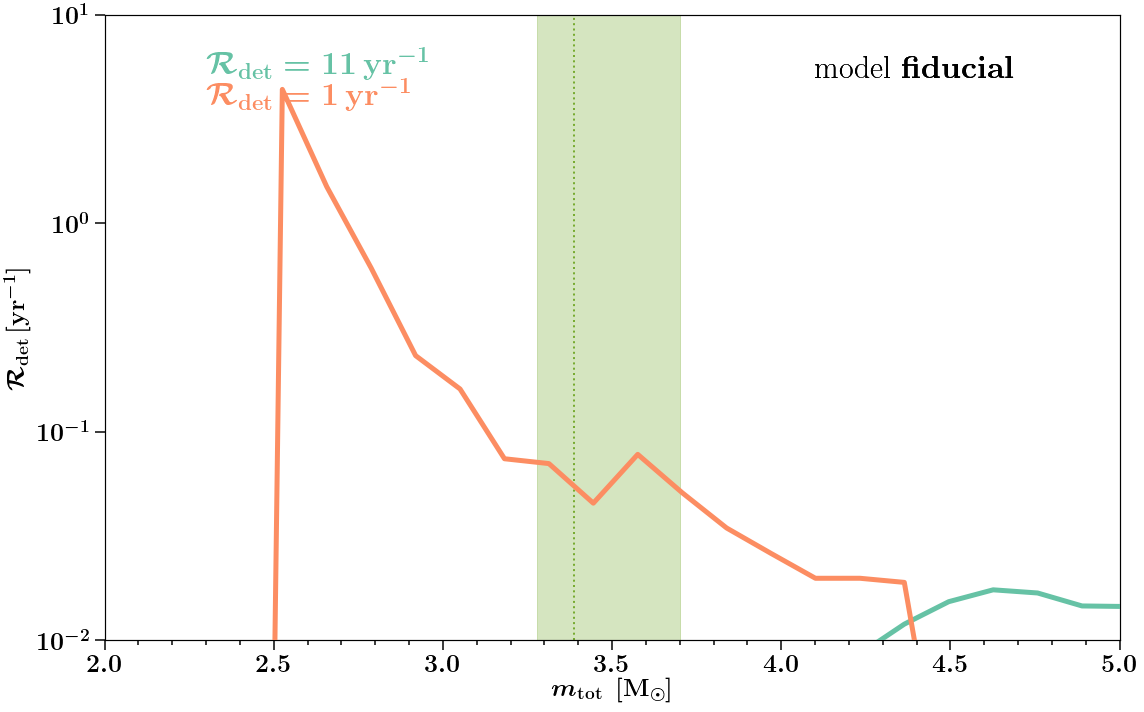

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= B
['000']
now at DCO BNS
now at m= B
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


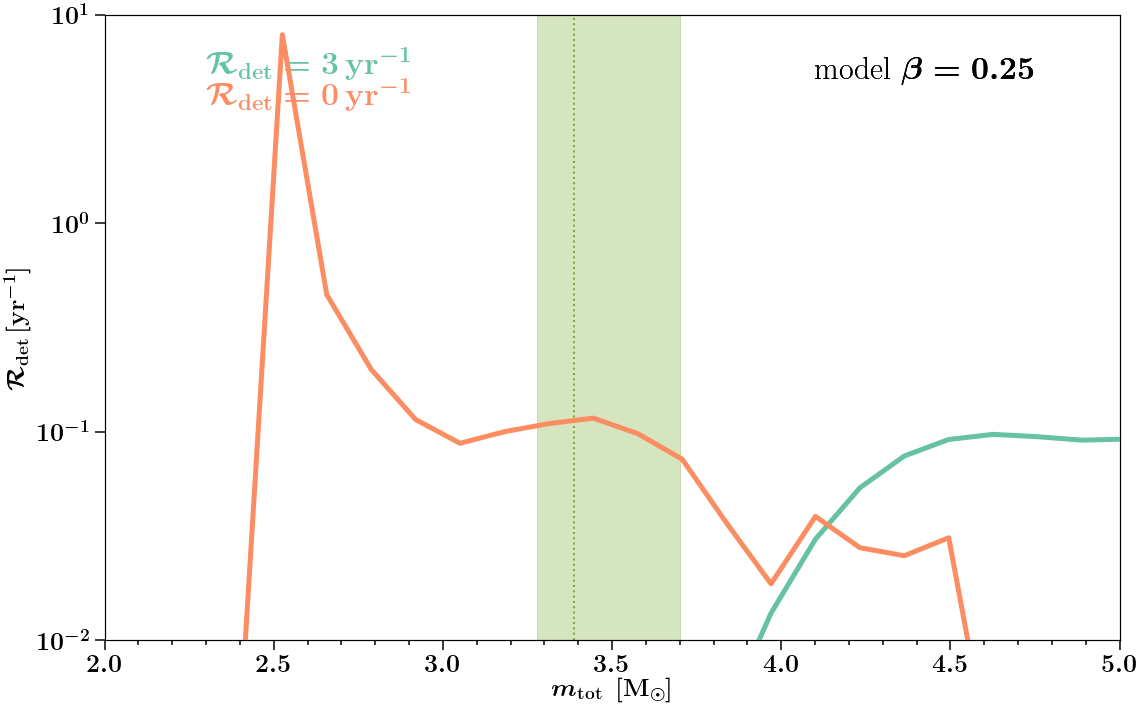

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= C
['000']
now at DCO BNS
now at m= C
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


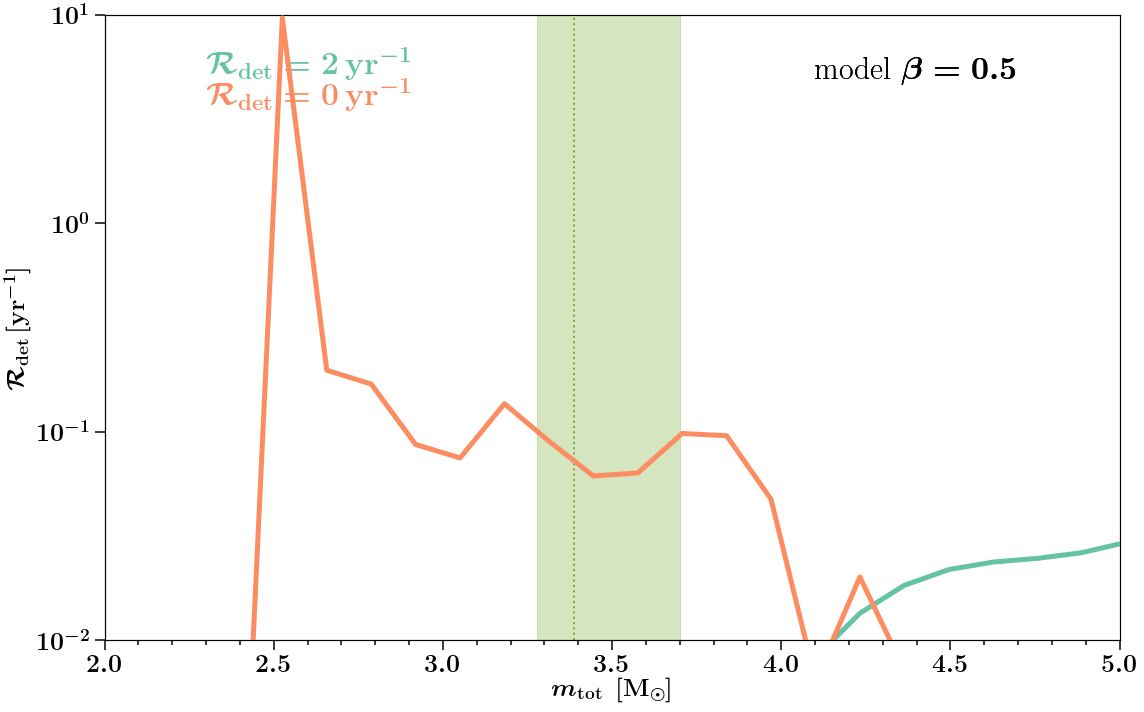

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= D
['000']
now at DCO BNS
now at m= D
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


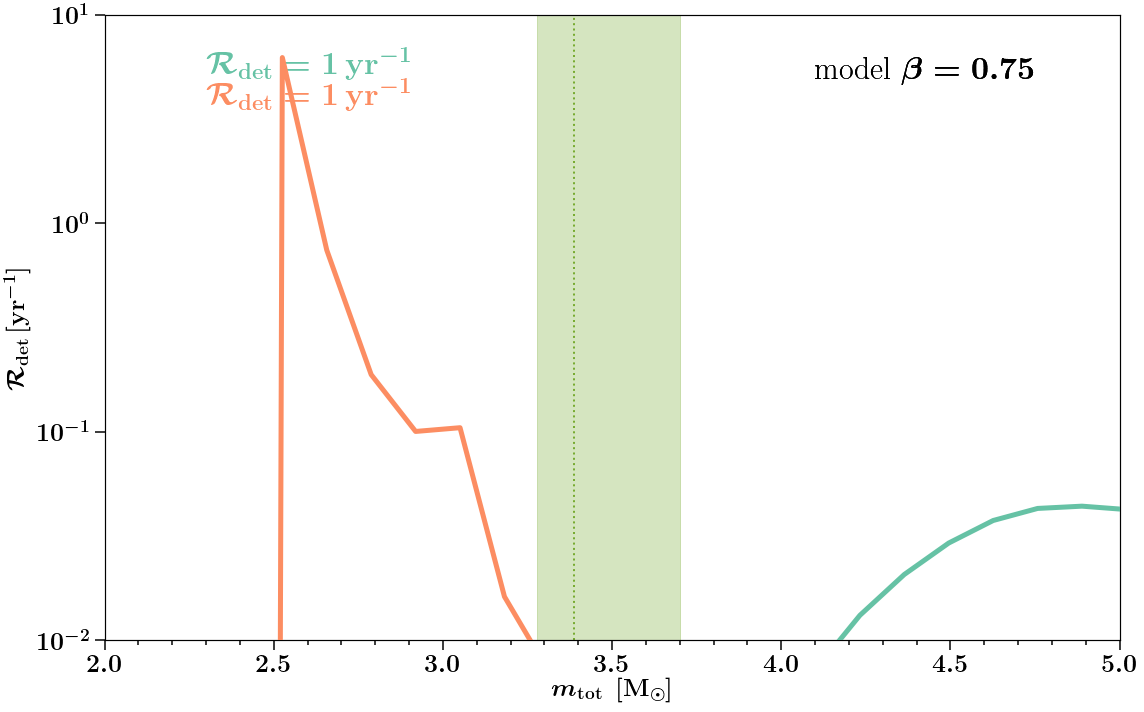

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= F
['000']
now at DCO BNS
now at m= F
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


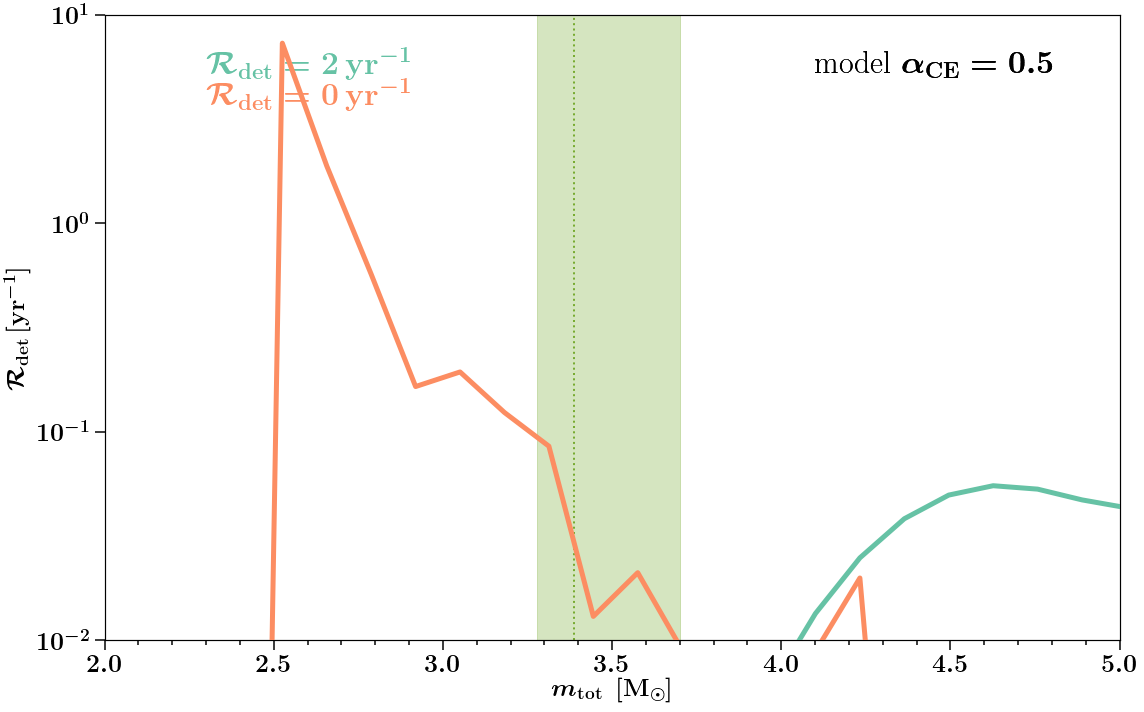

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= G
['000']
now at DCO BNS
now at m= G
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


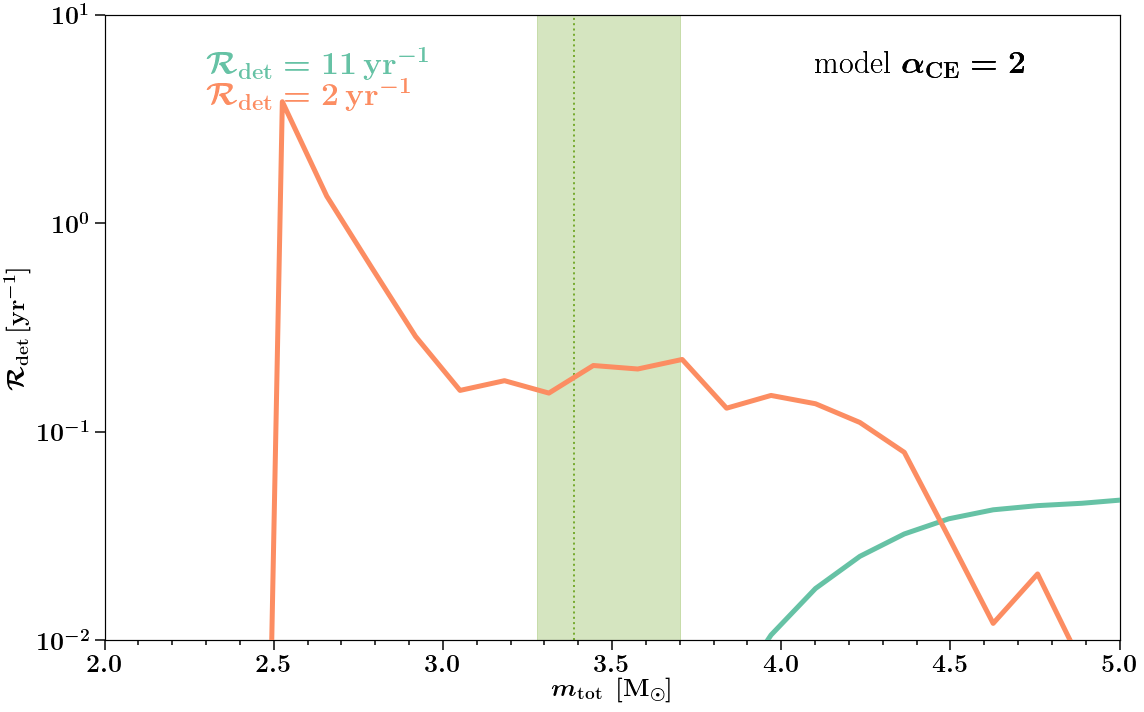

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= H
['000']
now at DCO BNS
now at m= H
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


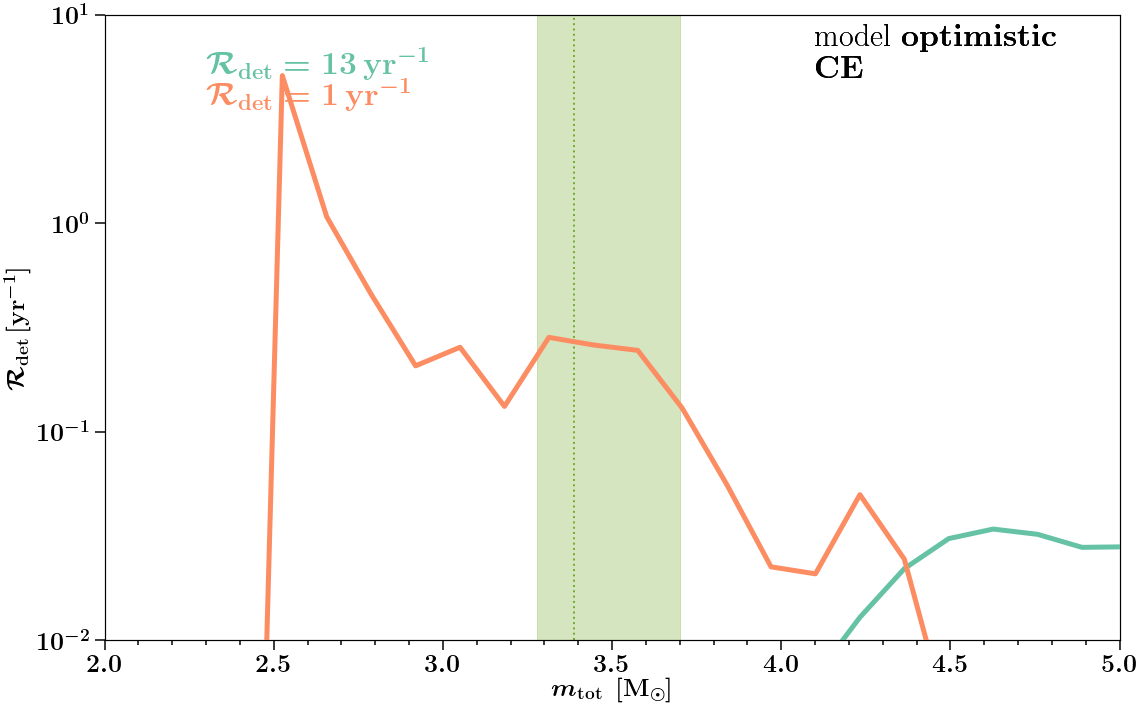

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= I
['000']
now at DCO BNS
now at m= I
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


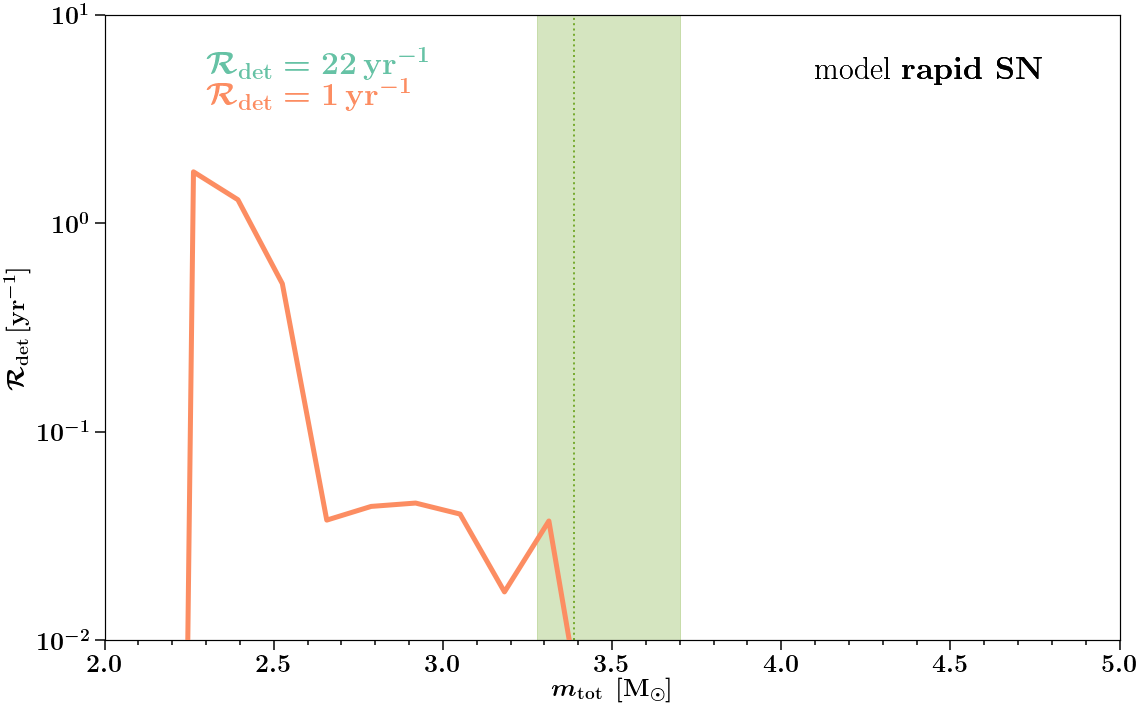

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= J
['000']
now at DCO BNS
now at m= J
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


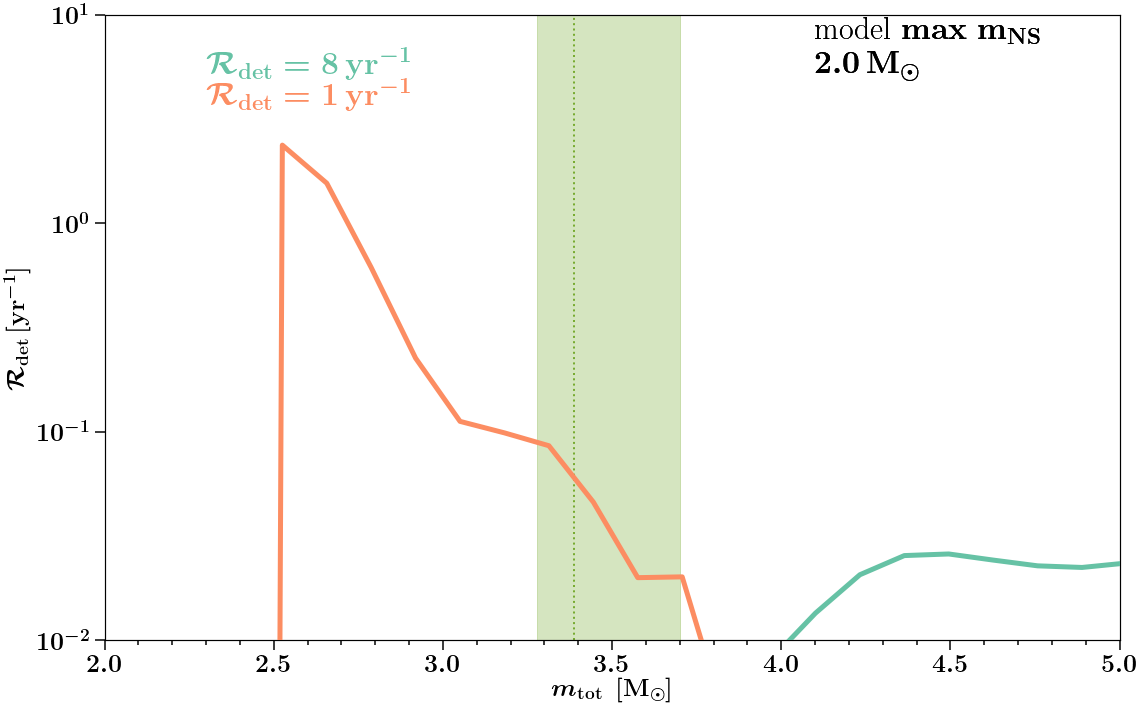

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= K
['000']
now at DCO BNS
now at m= K
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


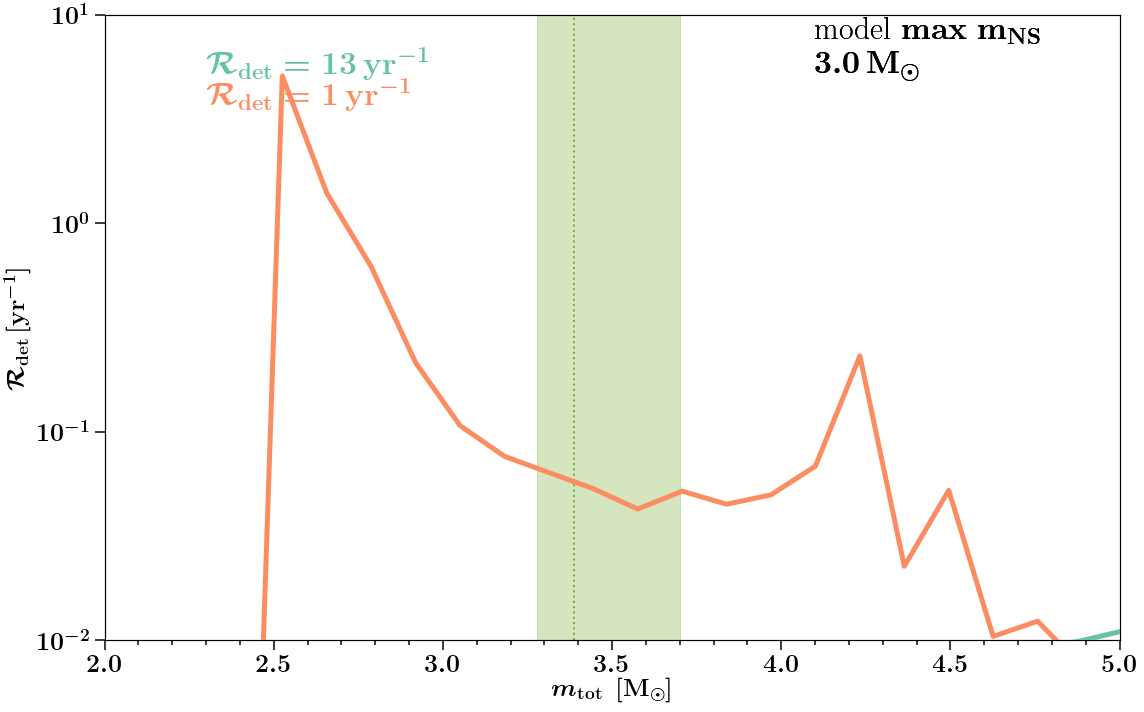

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= L
['000']
now at DCO BNS
now at m= L
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


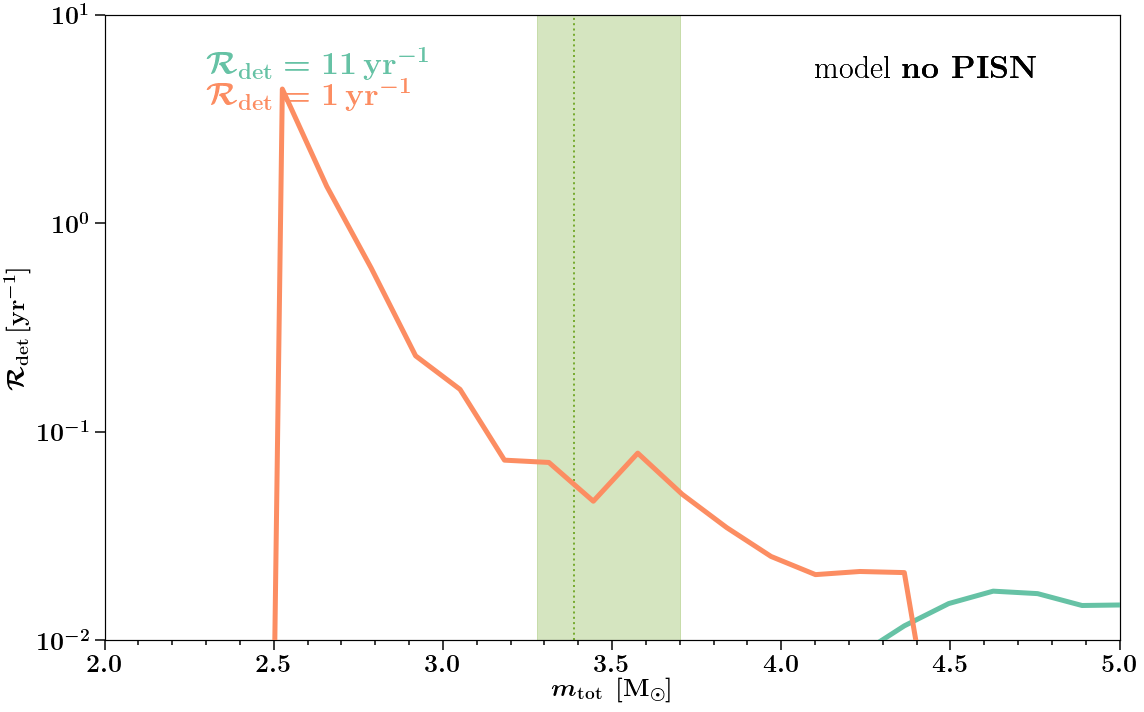

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= M
['000']
now at DCO BNS
now at m= M
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


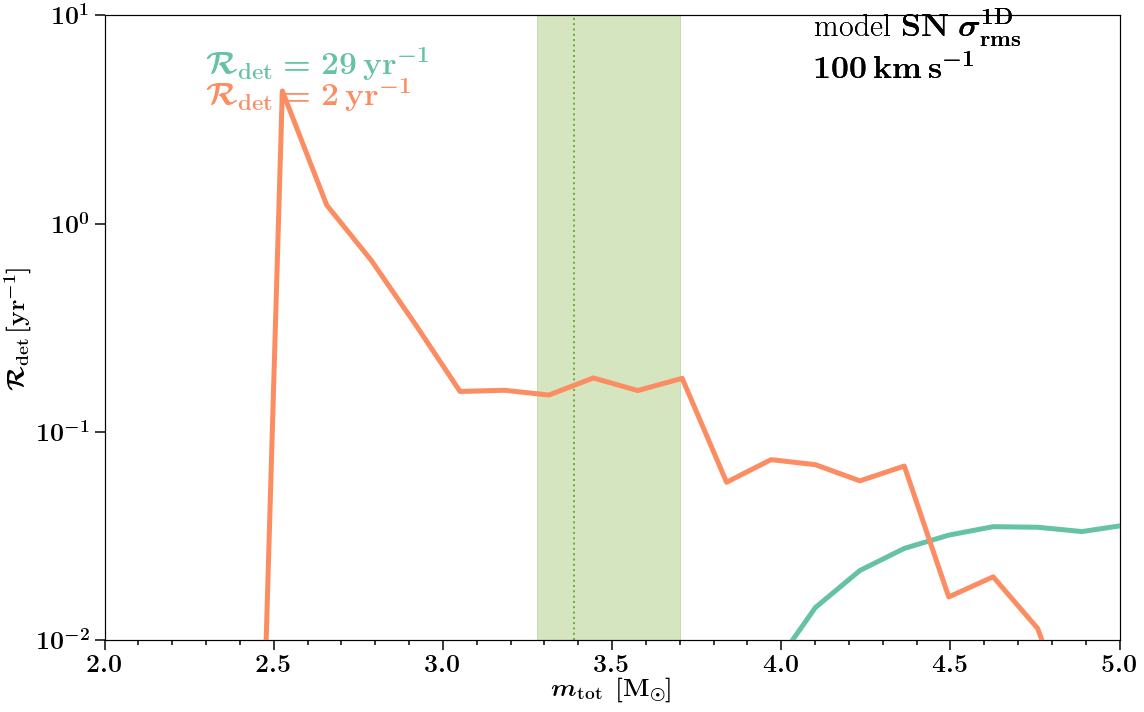

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= N
['000']
now at DCO BNS
now at m= N
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


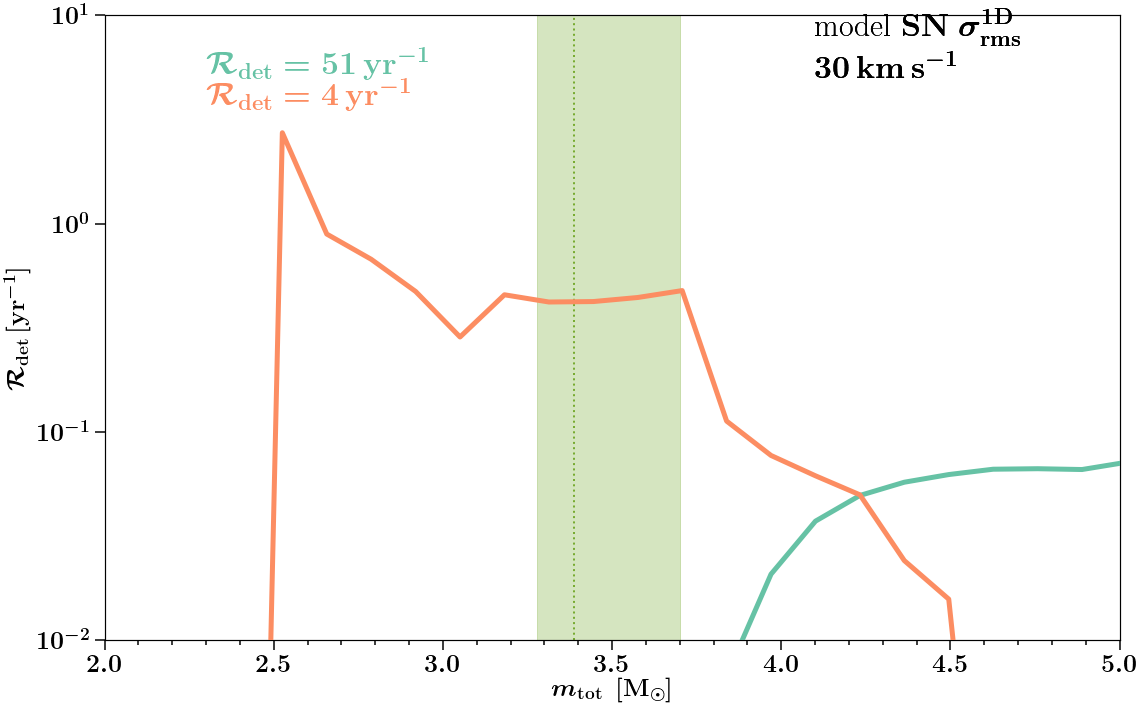

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= O
['000']
now at DCO BNS
now at m= O
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


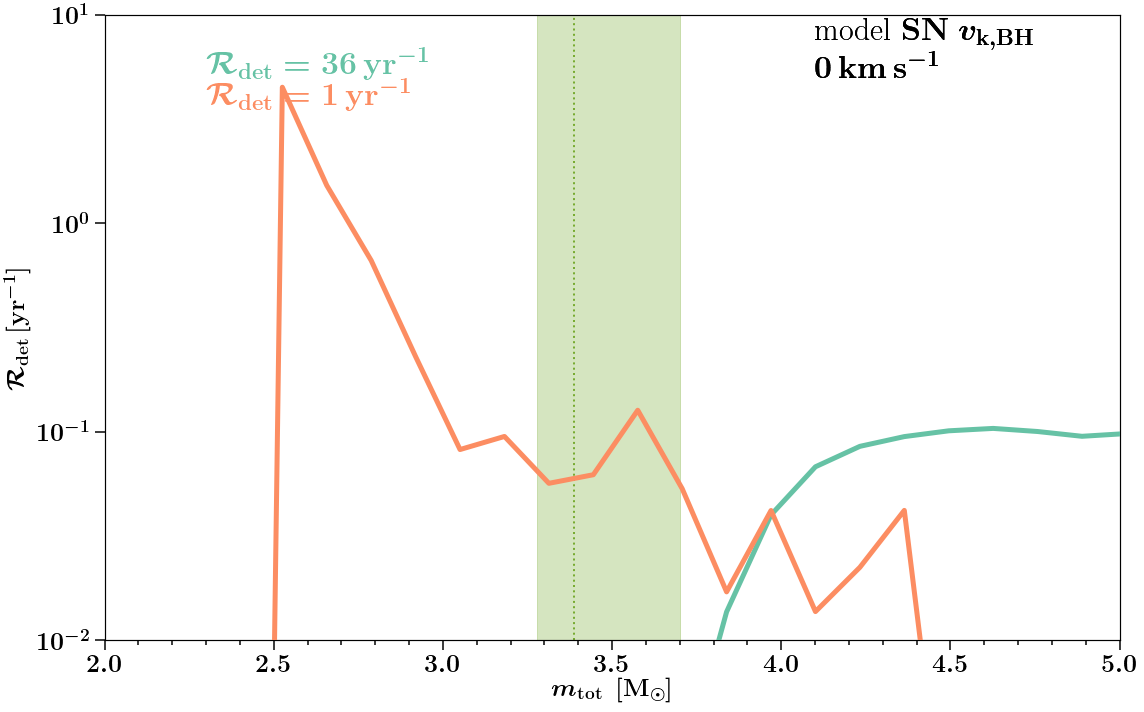

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= P
['000']
now at DCO BNS
now at m= P
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


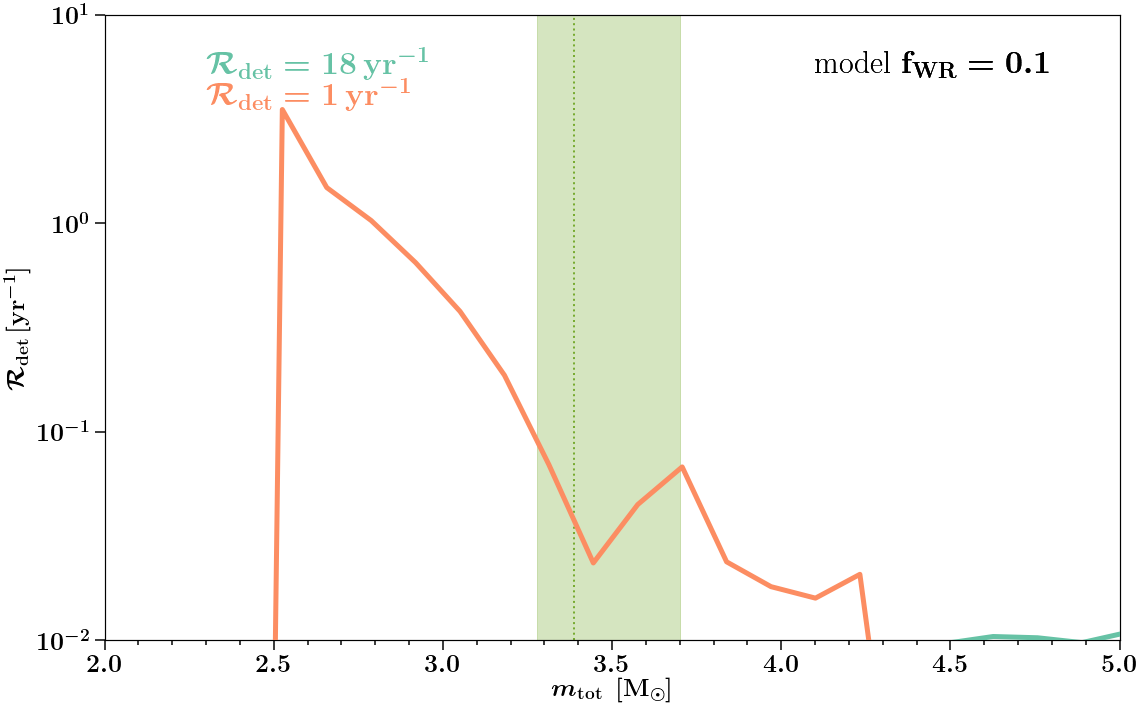

[3.2786646187620336, 3.7004914767156913]
now at DCO BHNS
now at m= Q
['000']
now at DCO BNS
now at m= Q
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


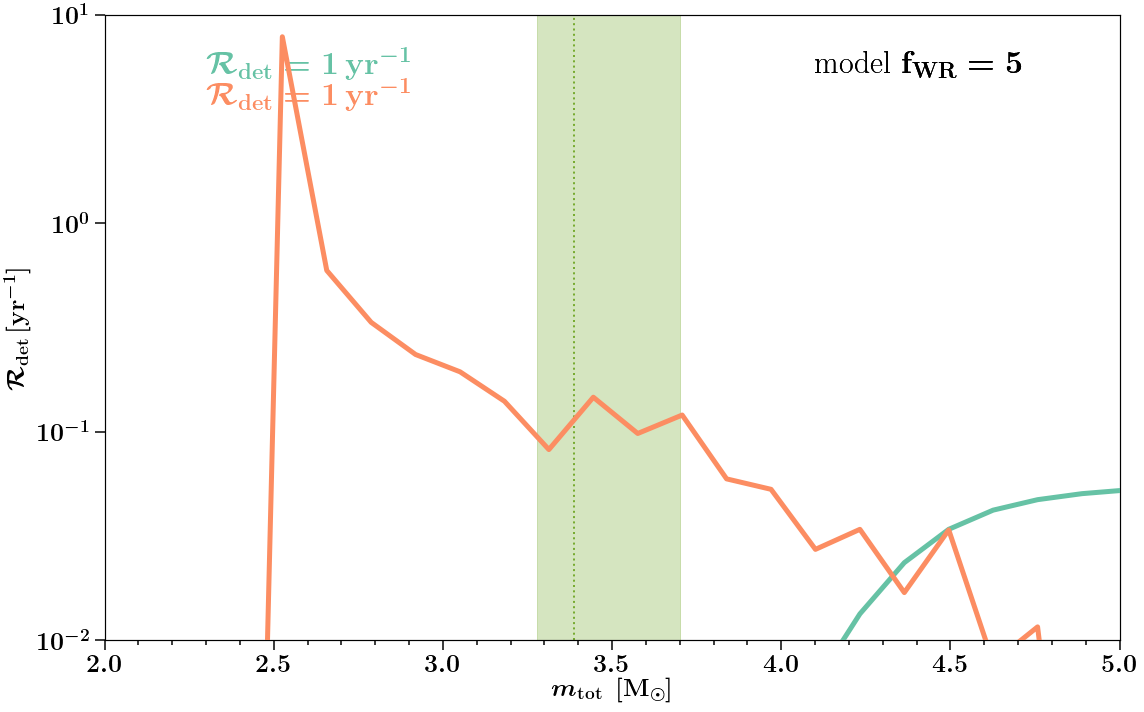

In [37]:

# add location of the COMPAS hdf5 files:
path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'





# for ind_bps, BPS in enumerate(['A']):#, 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']):
# Zsolar=0.0142

MSSFRalphas = [1., 0.5, 0.5, 0.5]
MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']


# MSSFRnameslist = ['000', '111', '211', '311', '112', '212', '312', '113', '213', '313', '121', '221', '321', '122', '222', '322', '123', '223', '323', '131', '231', '331', '132', '232', '332', '133', '233', '333']
# without z=1 SFRD models:
# MSSFRnameslist = ['000']#, '112', '212', '312', '113', '213', '313', '122', '222', '322', '123', '223', '323', '132', '232', '332', '133', '233', '333']
MSSFRnameslist = ['000']#, '112', '212', '312', '113', '213', '313', '122', '222', '322', '123', '223', '323', '132', '232', '332', '133', '233', '333']



# TYPE = 'BHNS'
nModels=17
BPSnameslist = list(string.ascii_uppercase)[0:nModels]
# BPScolors       = sns.color_palette("husl", len(BPSnameslist))
# colorDirDict =  {BPSnameslist[i]: BPScolors[i] for i in range(len(BPSnameslist))}

# I do NOT want model E 
if 'E' in BPSnameslist:
    BPSnameslist.remove('E')
print(BPSnameslist)

BPSnameslist =['N']



BPSnameslist_ = list(string.ascii_uppercase)[0:nModels]
if 'E' in BPSnameslist_:
    BPSnameslist_.remove('E')


for ind_m, model in enumerate(BPSnameslist_):
    BPSnameslist = [model]

    ncols, nrows= 1,1
    f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16,10), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    handles, labels = None, None


    # BPSlist = [BPS]
    whichWeight='det'


    nameY = r'$\mathcal{R}_{\rm{det}} \, [\rm{yr}^{-1}]   $'
    nameX = r' $m_{\rm{tot}} $ $ \,  [\rm{M}_{\odot}]$'
    xparam='Mtot'
    
    
    
    
    GWsGWTC  = [ 'GW190425']
    GWnames = ['GW190425']
    GW_colors =  sns.color_palette("husl", 10)
    GW_colors = [GW_colors[3], GW_colors[7]]
    GW_credible_interval(axe=axe, xparam='Mtot', GW_list = GWsGWTC, GW_names=GWnames, GW_colors=GW_colors, ylim=[0.01, 1E1])
    
    kde_comapre(axe_ind=1,xparam=xparam,  BPSmodelNames=BPSnameslist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtypes=['BHNS', 'BNS'], xvarrange=[2,15], xlabel=nameX, ylabel=nameY, \
                                  xlim=[2,5.], ylim=[0.,None], whichWeight=whichWeight,  path_dir=path_dir, quantiles=True)#, whichBPScolor=whichBPScolor)     

    make_up_axis(axe=axe, xlim=[2,5], ylim=[0.01, 1E1], nameX=nameX, nameY=nameY, logY=True, logX=False)

    

    
    

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)  
    plt.savefig('./discussion_Mass_tot_low' + whichWeight +'_'  +   BPSnameslist[0] +'.png', transparent=False)
    plt.show()
    plt.close()










In [14]:
GW_colors =  sns.color_palette("husl", 10)
GW_colors = GW_colors[3], GW_colors[7]
print(GW_colors)

((0.46810256823426105, 0.6699492535792404, 0.1928958739904499), (0.433280341176423, 0.6065273407962815, 0.9585467098271748))


['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q']
now at DCO BHNS
now at m= N
['000']
now at DCO BNS
now at m= N
['000']
now at DCO BBH
now at m= N
['000']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


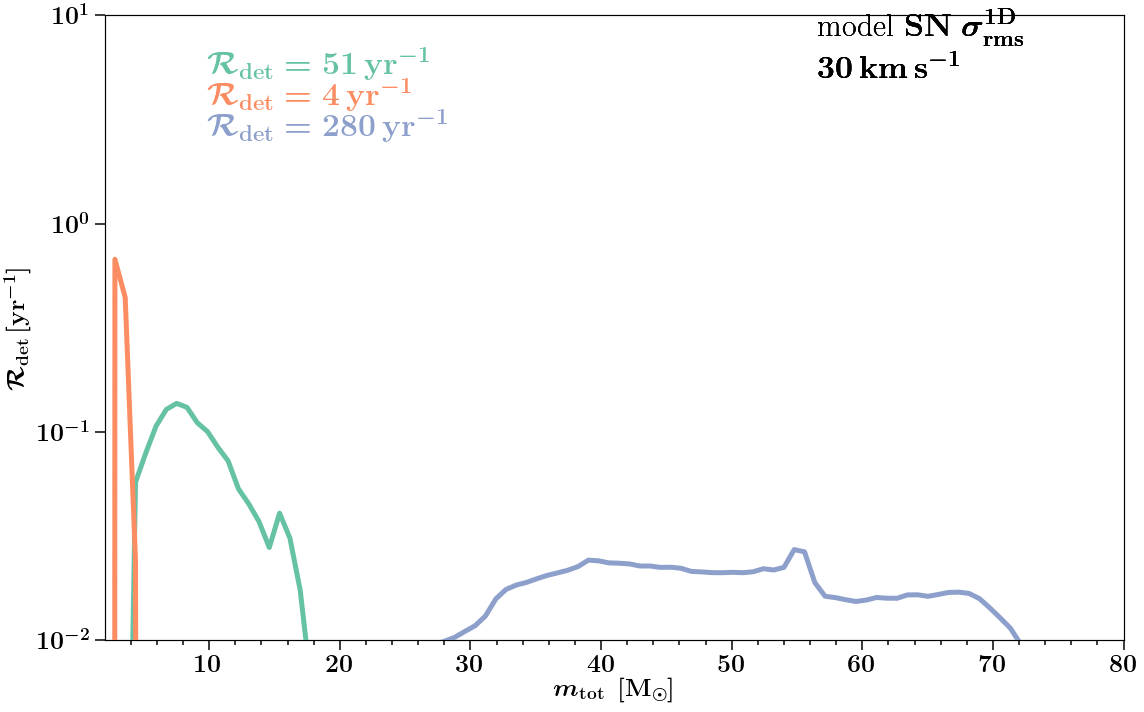

In [3]:

# add location of the COMPAS hdf5 files:
path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'






ncols, nrows= 1,1
f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16,10), 
              gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})


# for ind_bps, BPS in enumerate(['A']):#, 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']):
# Zsolar=0.0142

MSSFRalphas = [1., 0.5, 0.5, 0.5]
MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']


# MSSFRnameslist = ['000', '111', '211', '311', '112', '212', '312', '113', '213', '313', '121', '221', '321', '122', '222', '322', '123', '223', '323', '131', '231', '331', '132', '232', '332', '133', '233', '333']
# without z=1 SFRD models:
# MSSFRnameslist = ['000']#, '112', '212', '312', '113', '213', '313', '122', '222', '322', '123', '223', '323', '132', '232', '332', '133', '233', '333']
MSSFRnameslist = ['000']#, '112', '212', '312', '113', '213', '313', '122', '222', '322', '123', '223', '323', '132', '232', '332', '133', '233', '333']



# TYPE = 'BHNS'
nModels=17
BPSnameslist = list(string.ascii_uppercase)[0:nModels]
# BPScolors       = sns.color_palette("husl", len(BPSnameslist))
# colorDirDict =  {BPSnameslist[i]: BPScolors[i] for i in range(len(BPSnameslist))}

# I do NOT want model E 
if 'E' in BPSnameslist:
    BPSnameslist.remove('E')
print(BPSnameslist)

BPSnameslist =['N']





handles, labels = None, None
# BPSlist = [BPS]
whichWeight='det'


nameY = r'$\mathcal{R}_{\rm{det}} \, [\rm{yr}^{-1}]   $'
nameX = r' $m_{\rm{tot}} $ $ \,  [\rm{M}_{\odot}]$'
xparam='Mtot'
kde_comapre(axe_ind=1,xparam=xparam,  BPSmodelNames=BPSnameslist,\
        MSSFRmodelNames=MSSFRnameslist, DCOtypes=['BHNS', 'BNS', 'BBH'], xvarrange=[2,80], xlabel=nameX, ylabel=nameY, \
                              xlim=[2,80.], ylim=[0.,None], whichWeight=whichWeight,  path_dir=path_dir, quantiles=True)#, whichBPScolor=whichBPScolor)     

make_up_axis(axe=axe, xlim=[2,80], ylim=[0.01, 1E1], nameX=nameX, nameY=nameY, logY=True, logX=False)


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig('./discussion_Mass_tot_' + whichWeight +'_'  +   BPSnameslist[0] +'.png', transparent=False)
plt.show()
plt.close()










In [ ]:

# add location of the COMPAS hdf5 files:
path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'






ncols, nrows= 1,1
f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(16,10), 
              gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})


# for ind_bps, BPS in enumerate(['A']):#, 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']):
# Zsolar=0.0142

MSSFRalphas = [1., 0.5, 0.5, 0.5]
MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']


# MSSFRnameslist = ['000', '111', '211', '311', '112', '212', '312', '113', '213', '313', '121', '221', '321', '122', '222', '322', '123', '223', '323', '131', '231', '331', '132', '232', '332', '133', '233', '333']
# without z=1 SFRD models:
# MSSFRnameslist = ['000']#, '112', '212', '312', '113', '213', '313', '122', '222', '322', '123', '223', '323', '132', '232', '332', '133', '233', '333']
MSSFRnameslist = ['000']#, '112', '212', '312', '113', '213', '313', '122', '222', '322', '123', '223', '323', '132', '232', '332', '133', '233', '333']



# TYPE = 'BHNS'
nModels=17
BPSnameslist = list(string.ascii_uppercase)[0:nModels]
# BPScolors       = sns.color_palette("husl", len(BPSnameslist))
# colorDirDict =  {BPSnameslist[i]: BPScolors[i] for i in range(len(BPSnameslist))}

# I do NOT want model E 
if 'E' in BPSnameslist:
    BPSnameslist.remove('E')
print(BPSnameslist)

BPSnameslist =['N']





handles, labels = None, None
# BPSlist = [BPS]
whichWeight='det'


nameY = r'$\mathcal{R}_{\rm{det}} \, [\rm{yr}^{-1}]   $'
nameX = r' $m_{\rm{c}} $ $ \,  [\rm{M}_{\odot}]$'
xparam='Mchirp'
kde_comapre(axe_ind=1,xparam=xparam,  BPSmodelNames=BPSnameslist,\
        MSSFRmodelNames=MSSFRnameslist, DCOtypes=['BHNS', 'BNS', 'BBH'], xvarrange=[0.5,40], xlabel=nameX, ylabel=nameY, \
                              xlim=None, ylim=[0.,None], whichWeight=whichWeight,  path_dir=path_dir, quantiles=True)#, whichBPScolor=whichBPScolor)     

make_up_axis(axe=axe, xlim=[0.1,40], ylim=[0.01, 1E1], nameX=nameX, nameY=nameY, logY=True, logX=True)


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig('./discussion_Mass_chirp_' + whichWeight +'_'  + 'one_normed.png', transparent=False)
plt.show()
plt.close()








